# Ratio Put-Spread Strategy

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir():  # make sure it exists
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

#### __Defining the universe__
The entire execution pipeline is handled via the DataManager class, so we just add methods to the pipline which get executed once the pipeline is populated. Due to the volume of data to be processed, options chains are pulled in in parallel, processed and then deleted from memory. Necessary data are retained in the model and used for later inference. 

In [2]:
import options_wizard as ow
import pandas as pd

universe = ow.Universe()
universe.top_constituents(100)
universe.check_ticks()
data_manager = ow.DataManager(universe, load_lazy=True)
len(data_manager.universe.ticks)

C:\Users\cameronA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\exchange_calendars\exchange_calendar.py:2346: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),
C:\Users\cameronA\Desktop\options_wizard\src\universe.py:48: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  index_df["date"] = pd.to_datetime(index_df["date"])
C:\Users\cameronA\Desktop\options_wizard\src\universe.py:49: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  mktcap_df["date"] = pd.to_datetime(mktcap_df["date"])


 Removing QVCGA from universe - data not available          

210

#### __Transforming the Data__
Data transformations are those which will define the dataset for a given stock, that can be then used to infer features, returns and execute strategies. These methods can filter out contracts, changing the size of the options chain dataframe. These, along with the rest of the dataset are deleted once the tick's pipeline has been executed.

In [3]:
ow.Transformer(data_manager)('set_index', index_cols=['strike', 'trade_date', 'expiry_date', 'call_put'], dedupe=True)
ow.Transformer(data_manager)('get_underlying')
ow.Transformer(data_manager)('flag_chain_gaps', drop_on_gap = True)
ow.Transformer(data_manager)('scale_by_splits', upper_date = pd.Timestamp('2022-01-01'))
ow.Transformer(data_manager)('to_datetime', columns=['trade_date', 'expiry_date'])
ow.Transformer(data_manager)('flag_stale_options', volume_threshold=0)
ow.Transformer(data_manager)('drop_contract', drop = 'c')
ow.Transformer(data_manager)('avg_log_return')
ow.Transformer(data_manager)('pull_earnings_dates')
ow.Transformer(data_manager)('filter_ttms', min_ttm=3)
ow.Transformer(data_manager)('compute_rv', period=30)
ow.Transformer(data_manager)('train_test_split', upper_date=pd.Timestamp('2022-01-01').tz_localize('America/New_York'), drop_out_of_sample=True)
ow.Transformer(data_manager)('implied_volatility')
ow.Transformer(data_manager)('mid_price')

#### __Defining the Trade Strategy__
This defines the trade strategy for the model. It is important that the returns of the strategy are fit to the same row as the features of the strategy. Ie if you have an entry signal, the returns of the subsequent trade should be in the same column as the entry signal.

In [4]:
ow.Strategy(data_manager)('ratio_spread', lower_ttm=91, upper_ttm=121, delta_atm=0.3, delta_otm=0.1, otm_ratio=2, hold_period=30, call_put='p')
ow.Backtest(data_manager)('multi_day_entry', hold_period=30, propagate_columns=['avg_log_return'], entry_cost_size='short', entry_notional='underlying', initial_capital=1_000_000.0, capital_per_trade=12/(256), all_returns=True)
ow.Backtest(data_manager)('filter_by', col_name='avg_log_return', direction='max', n_taken=10, ndx_filter=True)
ow.Backtest(data_manager)("multi_stock", initial_capital=1_000_000,entry_notional = True, fixed_notional_exposure = 1_000_000*12/252,  allocation_basis="short")

#### __Model prediction and Pipeline Execution__
The model pipeline execution is paralelised accross available cores, this is defaulted to at 8 due to memory issues.

In [5]:
data_manager.execute_pipeline(retain_data=False, save_data=False, n_workers=2)

Deferring method multi_stock for all stocksAnalysis crashed for DISCA, reattempting, reason: 'NoneType' object has no attribute 'reset_index'
Analysis crashed for MYL, reattempting, reason: 'NoneType' object has no attribute 'reset_index'
Analysis crashed for CTXS, reattempting, reason: 'NoneType' object has no attribute 'reset_index'
Analysis crashed for KRFT, reattempting, reason: 'NoneType' object has no attribute 'reset_index'
Analysis crashed for DISCK, reattempting, reason: 'NoneType' object has no attribute 'reset_index'
Analysis crashed for DISH, reattempting, reason: 'NoneType' object has no attribute 'reset_index'
Analysis crashed for ALXN, reattempting, reason: 'NoneType' object has no attribute 'reset_index'
Analysis crashed for WBA, reattempting, reason: single positional indexer is out-of-bounds
Analysis crashed for GENZ, reattempting, reason: 'NoneType' object has no attribute 'reset_index'
Analysis crashed for NIHDQ, reattempting, reason: 'NoneType' object has no attrib

#### __Result Visualisation__ 

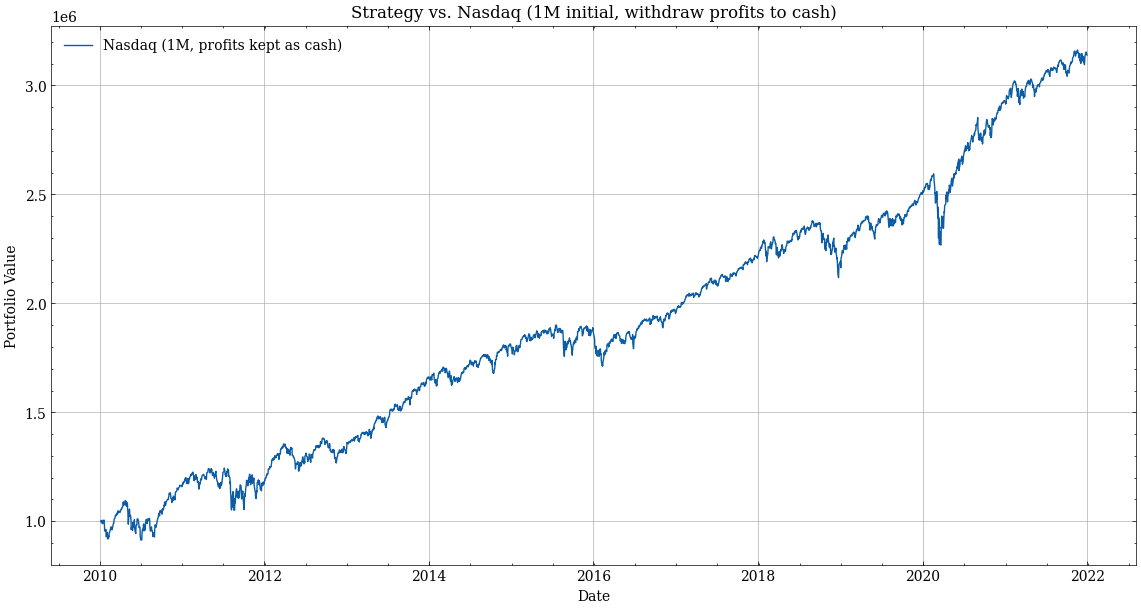

In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotx
import scienceplots
import matplotlib as mpl

plt.style.use('science')
mpl.rcParams['text.usetex'] = False

# ----------------------------
# Load Nasdaq and scale to 1M initial
# ----------------------------
nasdaq = yf.Ticker("^IXIC").history(
    start="2010-01-01", 
    end="2022-01-01", 
    interval="1d"
)['Close']

nasdaq_scaled = nasdaq / nasdaq.iloc[0] * 1_000_000


#--------------
# Compute “withdraw profits as cash” baseline
# ----------------------------
initial_value = 1_000_000

# Value of investment if we *never reinvest profits*
# Cash accumulates whenever the new equity > previous equity
cash = 0.0
baseline = pd.Series(index=nasdaq_scaled.index, dtype='float64')
baseline.iloc[0] = initial_value

for i in range(1, len(nasdaq_scaled)):
    cash += (nasdaq_scaled.iloc[i] - nasdaq_scaled.iloc[i - 1]) / nasdaq_scaled.iloc[i - 1] * initial_value
    baseline.iloc[i] = initial_value + cash

# ----------------------------
# Plot results
# ----------------------------
plt.figure(figsize=(14, 7))
#plt.plot(strategy.index, strategy, label="Strategy Equity")
plt.plot(baseline.index, baseline, label="Nasdaq (1M, profits kept as cash)")
plt.title("Strategy vs. Nasdaq (1M initial, withdraw profits to cash)")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


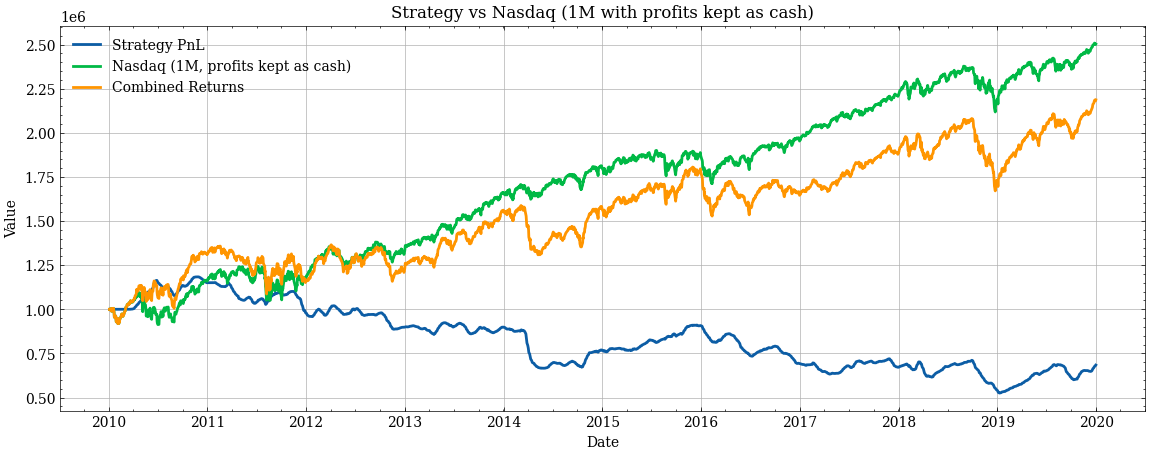

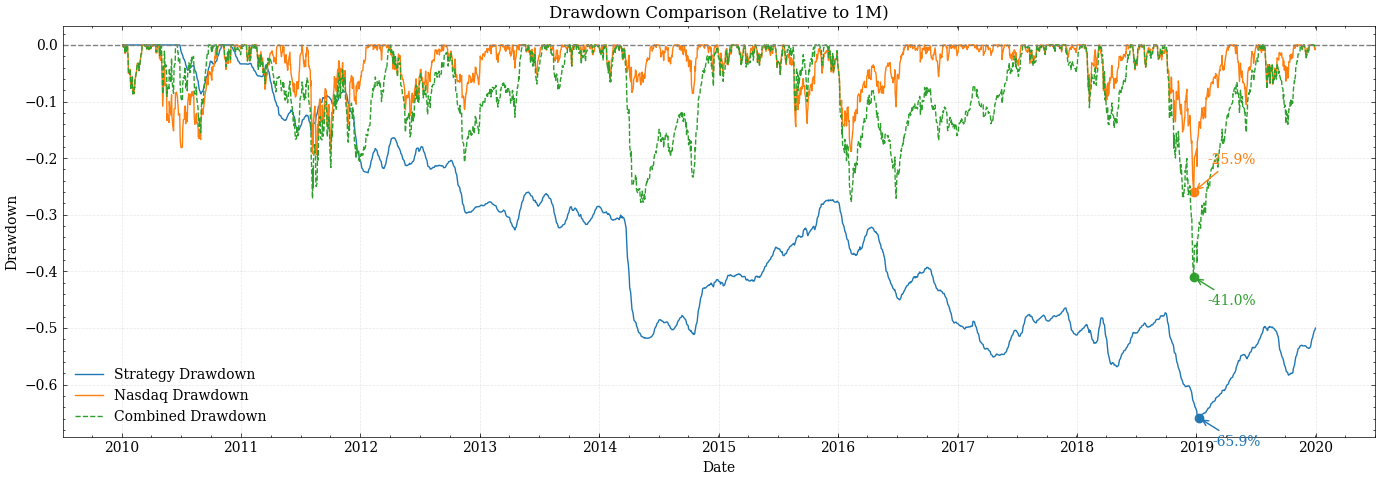

In [17]:


pos_val = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.current_pnl
        for c in x.active_contracts
    )
)

pnl_shorts = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.current_pnl
        for c in x.active_contracts if c.scaled_position < 0
    )
)

pnl_longs = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.current_pnl
        for c in x.active_contracts if c.scaled_position > 0
    )
)

pos_val.index = pos_val.index.tz_localize('America/New_York')
# ---- align indices ----
aligned = pd.concat([pos_val.cumsum(), baseline], axis=1, join="outer")
aligned = aligned[aligned.index < pd.Timestamp("2020-01-01").tz_localize('America/New_York')]
aligned.columns = ["strategy", "nasdaq"]

# ---- combined returns (strategy + nasdaq) ----
aligned["combined"] = aligned["strategy"] + aligned["nasdaq"]

# ---- plot ----
plt.figure(figsize=(14, 5))

#
# 
plt.plot(aligned.index, aligned["strategy"] + 1_000_000, label="Strategy PnL", linewidth=2)
plt.plot(aligned.index, aligned["nasdaq"], label="Nasdaq (1M, profits kept as cash)", linewidth=2)
plt.plot(aligned.index, aligned["combined"], label="Combined Returns", linewidth=2)

plt.title("Strategy vs Nasdaq (1M with profits kept as cash)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

strategy_equity = aligned["strategy"] + 1_000_000
nasdaq_equity = aligned["nasdaq"]
comb_equity = aligned["combined"]

strategy_drawdown = strategy_equity.div(1_000_000).sub(strategy_equity.cummax()/1_000_000)
nasdaq_drawdown = nasdaq_equity.div(1_000_000).sub(nasdaq_equity.cummax()/1_000_000)
combined_drawdown = (aligned["strategy"] + aligned["nasdaq"]).div(1_000_000).sub((aligned["strategy"] + aligned["nasdaq"]).cummax()/1_000_000)

strategy_mdd_date = strategy_drawdown.idxmin()
nasdaq_mdd_date = nasdaq_drawdown.idxmin()
combined_mdd_date = combined_drawdown.idxmin()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(strategy_drawdown.index, strategy_drawdown, label="Strategy Drawdown", color="tab:blue")
ax.plot(nasdaq_drawdown.index, nasdaq_drawdown, label="Nasdaq Drawdown", color="tab:orange")
ax.plot(aligned.index, combined_drawdown, label="Combined Drawdown", linestyle="--", color="tab:green")
ax.axhline(0, color="gray", linewidth=1, linestyle="--")

ax.scatter(strategy_mdd_date, strategy_drawdown.loc[strategy_mdd_date], color="tab:blue")
ax.scatter(nasdaq_mdd_date, nasdaq_drawdown.loc[nasdaq_mdd_date], color="tab:orange")
ax.scatter(combined_mdd_date,combined_drawdown.loc[combined_mdd_date], color="tab:green")

ax.annotate(
    f"{strategy_drawdown.loc[strategy_mdd_date]:.1%}",
    xy=(strategy_mdd_date, strategy_drawdown.loc[strategy_mdd_date]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color="tab:blue"),
    color="tab:blue"
)
ax.annotate(
    f"{nasdaq_drawdown.loc[nasdaq_mdd_date]:.1%}",
    xy=(nasdaq_mdd_date, nasdaq_drawdown.loc[nasdaq_mdd_date]),
    xytext=(10, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color="tab:orange"),
    color="tab:orange"
)
ax.annotate(
    f"{combined_drawdown.loc[combined_mdd_date]:.1%}",
    xy=(combined_mdd_date, combined_drawdown.loc[combined_mdd_date]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color="tab:green"),
    color="tab:green"
)

ax.set_title("Drawdown Comparison (Relative to 1M)")
ax.set_xlabel("Date")
ax.set_ylabel("Drawdown")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(frameon=False)
fig.tight_layout()


In [19]:
period_years = (comb_equity.index[-1] - comb_equity.index[0]) / pd.Timedelta(days=365.25)
print(period_years)

print((comb_equity.iloc[-1] / comb_equity.iloc[0] - 1) / period_years)
print((nasdaq_equity.iloc[-1] / nasdaq_equity.iloc[0] - 1) / period_years)
print((strategy_equity.iloc[-1] / strategy_equity.iloc[0] - 1) / period_years)

returns_comb = np.log(comb_equity - comb_equity.shift(1) + 1_000_000) - np.log(1_000_000)
returns_nasdaq = np.log(nasdaq_equity - nasdaq_equity.shift(1) + 1_000_000) - np.log(1_000_000)
returns_strategy = np.log(strategy_equity - strategy_equity.shift(1) + 1_000_000) - np.log(1_000_000)

vol_comb = returns_comb.std() * np.sqrt(252)
vol_nasdaq = returns_nasdaq.std() * np.sqrt(252)
vol_strategy = returns_strategy.std() * np.sqrt(252)

print("Combined Vol:", vol_comb)
print("Nasdaq Vol:", vol_nasdaq)
print("Strategy Vol:", vol_strategy)

sharpe_comb = returns_comb.mean() / returns_comb.std() * np.sqrt(252)
sharpe_nasdaq = returns_nasdaq.mean() / returns_nasdaq.std() * np.sqrt(252)
sharpe_strategy = returns_strategy.mean() / returns_strategy.std() * np.sqrt(252)

print("Combined Sharpe:", sharpe_comb)
print("Nasdaq Sharpe:", sharpe_nasdaq)
print("Strategy Sharpe:", sharpe_strategy)

correlation = returns_comb.corr(returns_nasdaq)
strat_correlation = returns_strategy.corr(returns_nasdaq)
print("Correlation between Strategy and Nasdaq returns:", strat_correlation)
print("Correlation between Combined and Nasdaq returns:", correlation)

print("Strategy Skew" , returns_strategy.skew())
print("Nasdaq Skew" , returns_nasdaq.skew())
print("Combined Skew" , returns_comb.skew())


9.987679671457906
0.11886332272094229
0.15051523841325487
-0.03165191569231262
Combined Vol: 0.18111733460015378
Nasdaq Vol: 0.17077267786273498
Strategy Vol: 0.03608675577766957
Combined Sharpe: 0.5662657244807815
Nasdaq Sharpe: 0.7965625525187834
Strategy Sharpe: -0.8958477328305751
Correlation between Strategy and Nasdaq returns: 0.18694066659136058
Correlation between Combined and Nasdaq returns: 0.9805873658697334
Strategy Skew -0.7911404263042295
Nasdaq Skew -0.4555512103900028
Combined Skew -0.504086067369553


In [18]:
delta = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.scaled_position * c.delta * c.underlying_close
        for c in x.active_contracts
    ) / sum(
        c.scaled_position * c.underlying_close
        for c in x.active_contracts
    ) if sum(
        c.scaled_position * c.underlying_close
        for c in x.active_contracts
    ) != 0 else 0.0
)
theta = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.scaled_position * c.theta
        for c in x.active_contracts
    )
)

vega = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.scaled_position * c.vega
        for c in x.active_contracts
    )
)

def as_naive_date(ts):
    ts = pd.to_datetime(ts)
    return ts.tz_localize(None).normalize() if ts.tzinfo else ts.normalize()

entry_cost = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.scaled_position * c.last_price
        for c in x.active_contracts
        if as_naive_date(c.entry_date) == as_naive_date(x.date)
    )
)

mean_delta = delta.mean()
mean_theta = theta.mean()
mean_vega = vega.mean()
mean_entry_cost = entry_cost.mean()

std_delta = delta.std()
std_theta = theta.std()
std_vega = vega.std()
std_entry_cost = entry_cost.std()

skew_delta = delta.skew()
skew_theta = theta.skew()
skew_vega = vega.skew()
skew_entry_cost = entry_cost.skew()

print("Mean Delta:", mean_delta, "Std Dev:", std_delta, "Skew:", skew_delta)
print("Mean Theta:", mean_theta, "Std Dev:", std_theta, "Skew:", skew_theta)
print("Mean Vega:", mean_vega, "Std Dev:", std_vega, "Skew:", skew_vega)
print("Mean Entry Cost:", mean_entry_cost, "Std Dev:", std_entry_cost, "Skew:", skew_entry_cost)

Mean Delta: 0.04079622603409585 Std Dev: 0.023234645787720686 Skew: -1.3395391942609283
Mean Theta: -522.8812406276608 Std Dev: 665.1461558844877 Skew: -3.389101204787194
Mean Vega: 885.1991540485762 Std Dev: 2216.0411677780603 Skew: 1.3083761806959582
Mean Entry Cost: -472.10153246958805 Std Dev: 381.43869487121464 Skew: -1.1842179727175235


In [10]:
data_manager.combined_outputs['multi_stock']['equity_obj'].iloc[100].active_contracts[0].theta

-0.0181

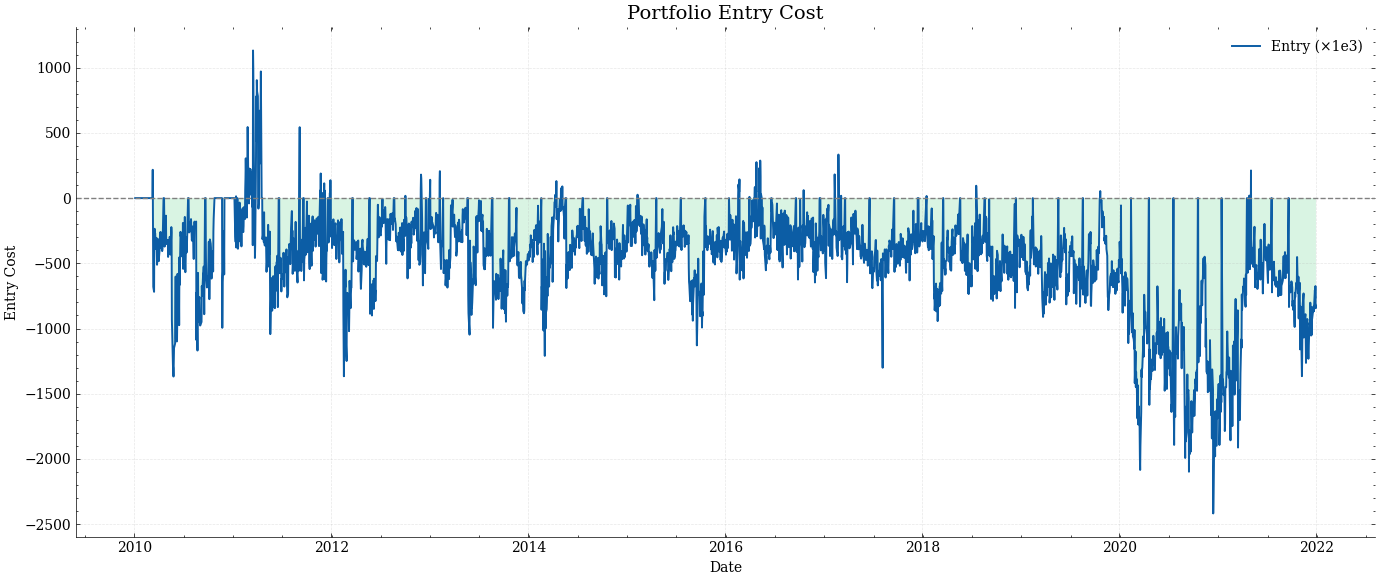

In [11]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(entry_cost.index, entry_cost, linewidth=1.4, label='Entry (×1e3)')
ax.fill_between(delta.index, 0, entry_cost, where=entry_cost >= 0, alpha=0.15)
ax.fill_between(delta.index, 0, entry_cost, where=entry_cost < 0, alpha=0.15)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('Portfolio Entry Cost', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Entry Cost')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(frameon=False, loc='upper right')
fig.tight_layout()

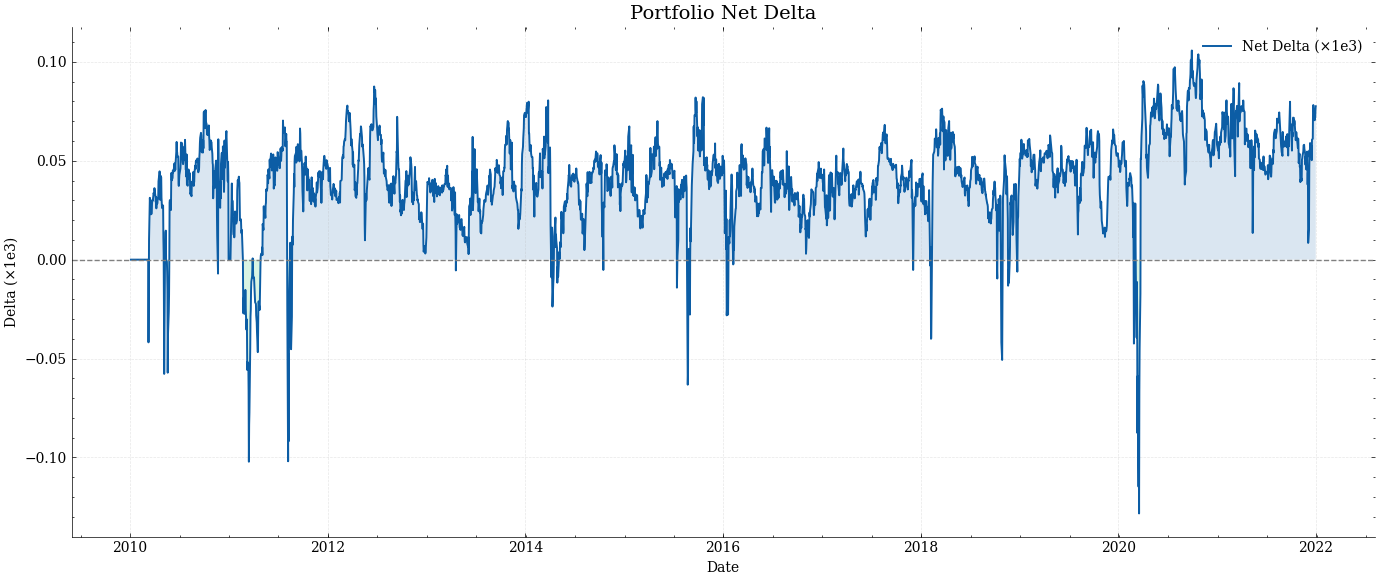

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))
delta_scaled = delta 
ax.plot(delta.index, delta_scaled, linewidth=1.4, label='Net Delta (×1e3)')
ax.fill_between(delta.index, 0, delta_scaled, where=delta_scaled >= 0, alpha=0.15)
ax.fill_between(delta.index, 0, delta_scaled, where=delta_scaled < 0,  alpha=0.15)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('Portfolio Net Delta', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Delta (×1e3)')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(frameon=False, loc='upper right')
fig.tight_layout()

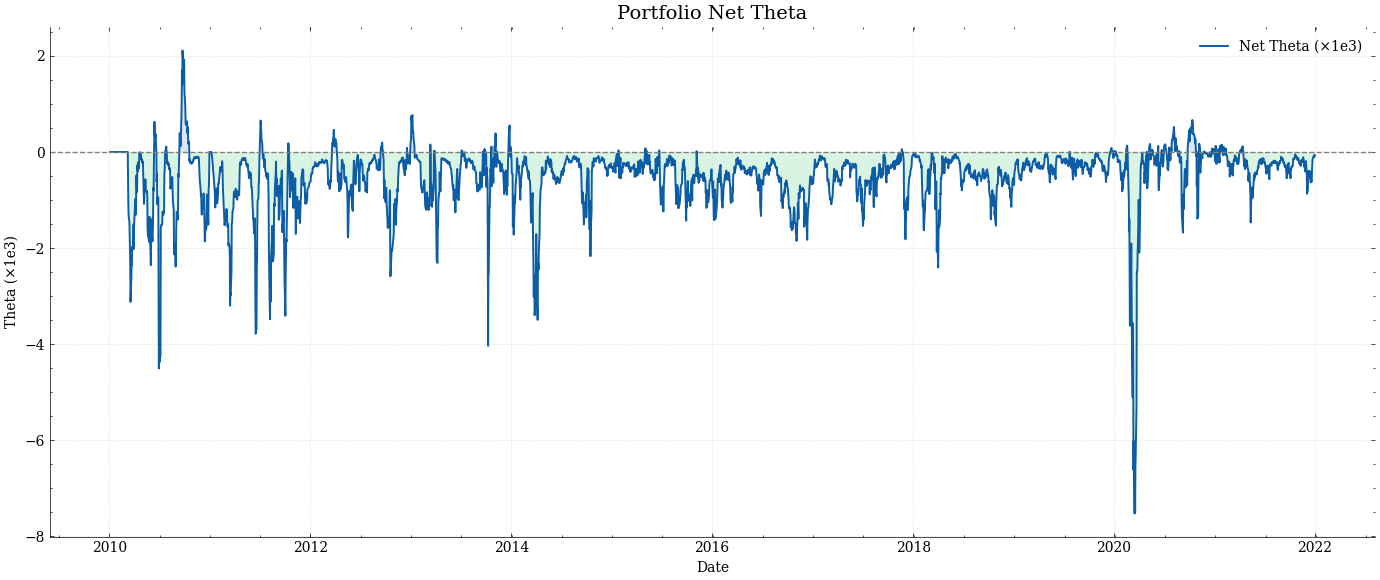

In [13]:
fig, ax = plt.subplots(figsize=(14, 6))
theta = theta / 1e3
ax.plot(theta.index, theta,  linewidth=1.4, label='Net Theta (×1e3)')
ax.fill_between(theta.index, 0, theta, where=theta >= 0, alpha=0.15)
ax.fill_between(theta.index, 0, theta, where=theta < 0, alpha=0.15)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('Portfolio Net Theta', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Theta (×1e3)')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(frameon=False, loc='upper right')
fig.tight_layout()

C:\Users\cameronA\AppData\Local\Temp\ipykernel_21388\2595152652.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=allocation.index.min(), end=allocation.index.max())
[*********************100%***********************]  1 of 1 completed


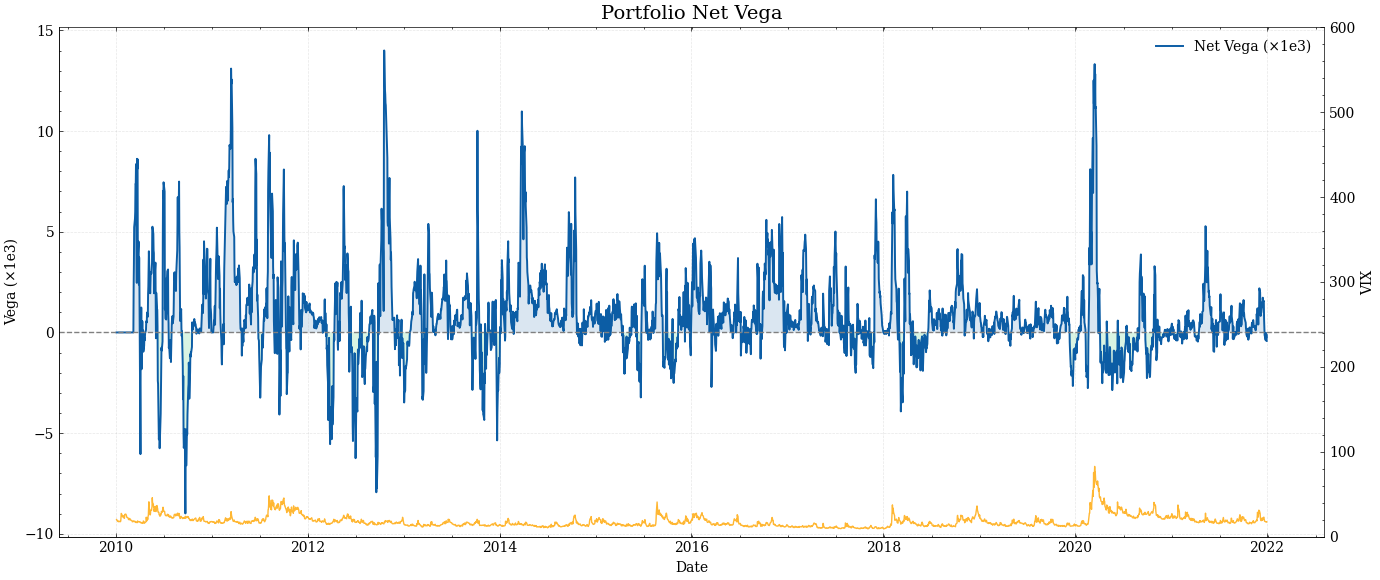

In [14]:

import yfinance as yf

# Get VIX and align to allocation dates
start = vega.index.min()
end = vega.index.max()
before = data_manager.combined_outputs
allocation = before['multi_stock']['allocation_underlying_value'].dropna()[start:end]
vix = yf.download("^VIX", start=allocation.index.min(), end=allocation.index.max())
vix = vix['Close'].reindex(allocation.index).ffill()

fig, ax = plt.subplots(figsize=(14, 6))
vega_scaled = vega / 1e3
ax.plot(vega.index, vega_scaled,  linewidth=1.4, label='Net Vega (×1e3)')
ax.fill_between(vega.index, 0, vega_scaled, where=vega_scaled >= 0, alpha=0.15)
ax.fill_between(vega.index, 0, vega_scaled, where=vega_scaled < 0, alpha=0.15)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('Portfolio Net Vega', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Vega (×1e3)')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(frameon=False, loc='upper right')


ax2 = ax.twinx()
ax2.plot(vix.index, vix, linewidth=1, alpha=0.8, color='orange', label='VIX Level')
ax2.set_ylabel('VIX')
ax2.set_ylim(0, 600)
#ax.axvline(pd.Timestamp("2020-02-15"), color='gray', linestyle='--', linewidth=2, label='Covid')
fig.tight_layout()


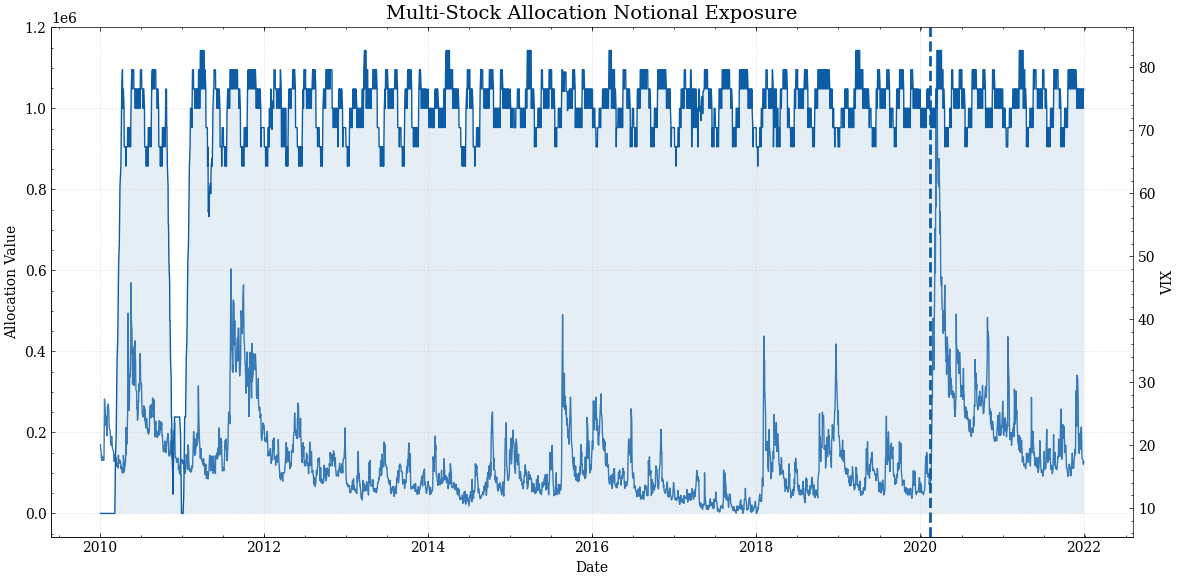

In [15]:

fig, ax = plt.subplots(figsize=(12, 6))

# Left y-axis: allocation
ax.plot(allocation.index, allocation, linewidth=1)
ax.fill_between(allocation.index, allocation,  alpha=0.1)

ax.set_title('Multi-Stock Allocation Notional Exposure', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Allocation Value')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Right y-axis: VIX
ax2 = ax.twinx()
ax2.plot(vix.index, vix, linewidth=1, alpha=0.8)
ax2.set_ylabel('VIX')
ax.axvline(pd.Timestamp("2020-02-15"), linestyle='--', linewidth=2, label='Covid')
fig.tight_layout()


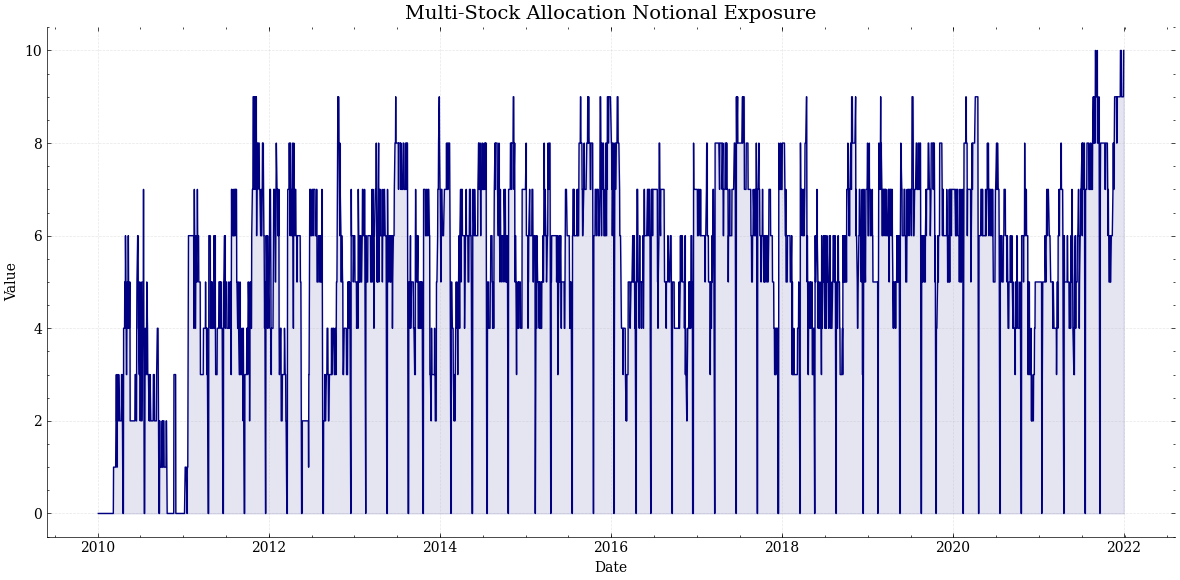

In [16]:
before = data_manager.combined_outputs
allocation = before['multi_stock']['stocks_entered'].dropna()[start:end]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(allocation.index, allocation, color='navy', linewidth=1)
ax.fill_between(allocation.index, allocation, color='navy', alpha=0.1)
ax.set_title('Multi-Stock Allocation Notional Exposure', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()